In [47]:
import cv2
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestRegressor
import joblib
from pathlib import Path

In [48]:

import matplotlib.pyplot as plt

class AdvancedColorCorrector:
    def __init__(self, model_path=None):
        """Initialize with optional pre-trained model"""
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        if model_path and Path(model_path).exists():
            self.load_model(model_path)
        else:
            self.initialize_with_sample_data()

    def initialize_with_sample_data(self):
        """Strong default corrections for common color issues"""
        X_sample = np.array([
            [120, 140, 120, 10, 15, 0.2, -0.3],  # Warm
            [130, 120, 140, 8, 12, -0.1, 0.2],    # Cool
            [110, 130, 110, 12, 10, 0.3, -0.4],   # Yellow
            [125, 110, 130, 9, 11, -0.3, 0.1],    # Blue
            [118, 128, 128, 11, 12, 0.0, 0.0]     # Neutral
        ])

        y_sample = np.array([
            [0.7, 1.3],  # Strong warmth reduction
            [1.3, 0.7],  # Strong coolness reduction
            [0.6, 1.4],  # Strong yellow correction
            [1.4, 0.6],  # Strong blue correction
            [1.0, 1.0]   # Neutral
        ])

        self.model.fit(X_sample, y_sample)

    def extract_features(self, img):
        """Extract LAB color statistics"""
        lab = cv2.cvtColor(np.array(img)[:, :, :3], cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        a = a.astype(np.float32) - 128
        b = b.astype(np.float32) - 128

        return [
            np.mean(l),
            np.mean(a) + 128,
            np.mean(b) + 128,
            np.std(a),
            np.std(b),
            self._calculate_skew(a),
            self._calculate_skew(b)
        ]

    def _calculate_skew(self, channel):
        mean = np.mean(channel)
        std = np.std(channel)
        return 0 if std == 0 else np.mean(((channel - mean) / std) ** 3)

    def predict_correction(self, img):
        features = np.array(self.extract_features(img)).reshape(1, -1)
        a_adj, b_adj = self.model.predict(features)[0]
        return np.clip(a_adj, 0.6, 1.4), np.clip(b_adj, 0.6, 1.4)

    def save_model(self, path):
        joblib.dump(self.model, path)

    def load_model(self, path):
        self.model = joblib.load(path)

def apply_lab_correction(img, a_adj, b_adj):
    """Apply LAB space color correction"""
    img_array = np.array(img)[:, :, :3].astype(np.uint8)
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    a = ((a.astype(np.float32) - 128) * a_adj) + 128
    b = ((b.astype(np.float32) - 128) * b_adj) + 128

    corrected_lab = cv2.merge([l, np.clip(a, 0, 255).astype(np.uint8),
                             np.clip(b, 0, 255).astype(np.uint8)])
    return cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2RGB)

def adjust_saturation(img, factor=1.2):
    """Adjust saturation in HSV space"""
    if factor == 1.0:
        return img

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    s = np.clip(s.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    return cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2RGB)

def plot_results(original, corrected):
    """Display images with RGB histograms"""
    plt.figure(figsize=(16, 8))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    # Corrected image
    plt.subplot(2, 3, 2)
    plt.imshow(corrected)
    plt.title("Corrected Image")
    plt.axis('off')

    # Histograms
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        # Original histogram
        plt.subplot(2, 3, 4)
        hist = cv2.calcHist([original], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.title("Original Histogram")
        plt.xlim([0, 256])

        # Corrected histogram
        plt.subplot(2, 3, 5)
        hist = cv2.calcHist([corrected], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.title("Corrected Histogram")
        plt.xlim([0, 256])

        # Histogram differences
        plt.subplot(2, 3, 6)
        orig_hist = cv2.calcHist([original], [i], None, [256], [0, 256])
        corr_hist = cv2.calcHist([corrected], [i], None, [256], [0, 256])
        plt.plot(corr_hist - orig_hist, color=color)
        plt.title("Histogram Differences")
        plt.axhline(0, color='black', linestyle='--')
        plt.xlim([0, 256])

    plt.tight_layout()
    plt.show()

def full_color_correction(input_img, corrector, saturation_factor=1.2):
    """Complete correction pipeline"""
    if isinstance(input_img, np.ndarray):
        img = Image.fromarray(input_img).convert("RGB")
    else:
        img = input_img.convert("RGB")

    # Apply ML correction
    a_adj, b_adj = corrector.predict_correction(img)
    corrected = apply_lab_correction(img, a_adj, b_adj)

    # Apply saturation if needed
    if saturation_factor != 1.0:
        corrected = adjust_saturation(corrected, saturation_factor)

    return corrected



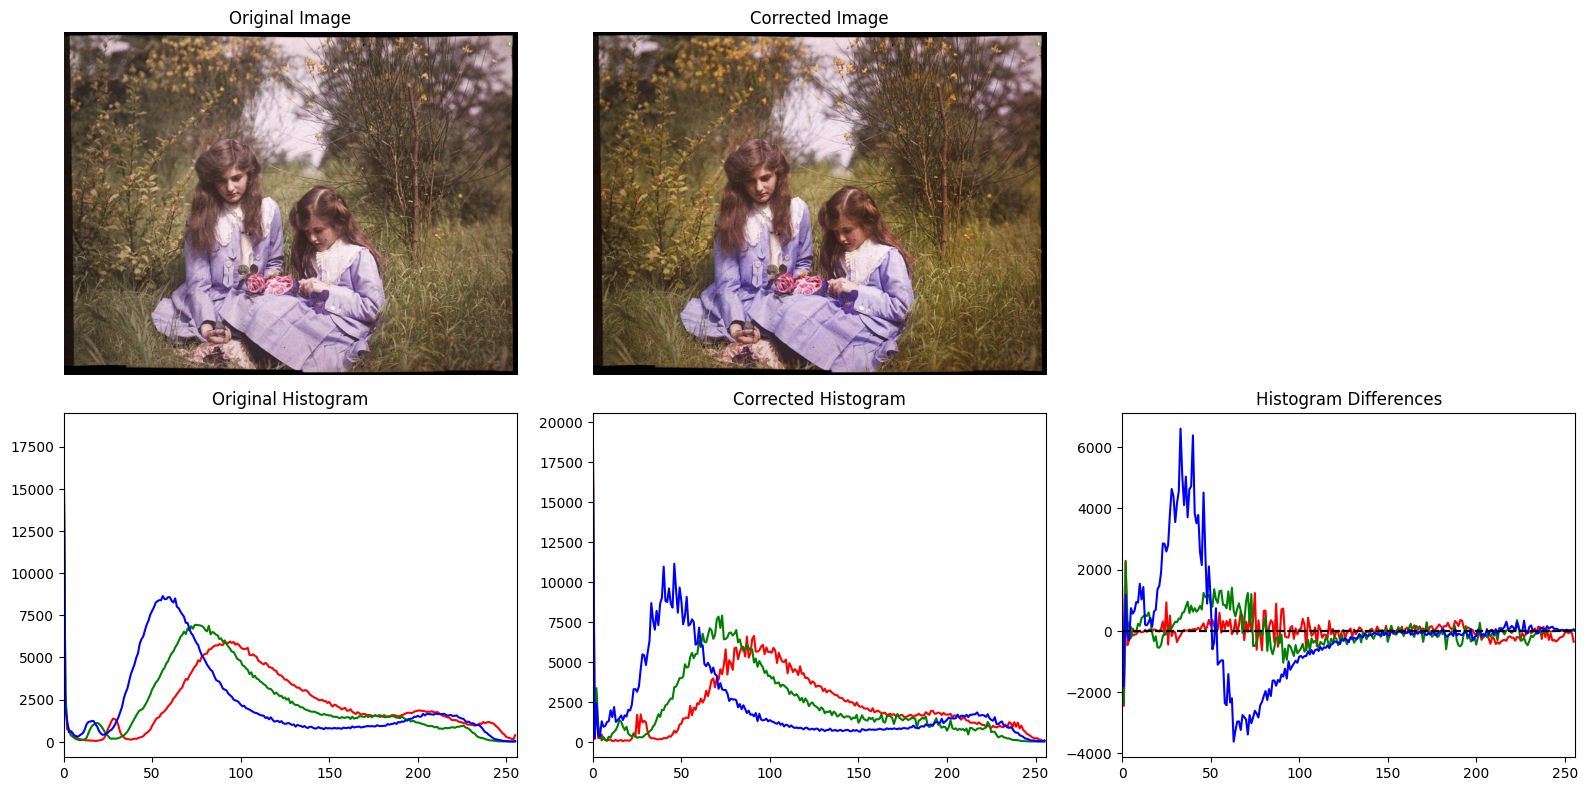

In [49]:

# Example usage
if __name__ == "__main__":
    # Initialize corrector with strong defaults
    corrector = AdvancedColorCorrector()

    # Load and process image
    input_img = Image.open("image11.jpg")
    corrected_img = full_color_correction(input_img, corrector, saturation_factor=1.3)

    # Convert to numpy arrays for display
    original_array = np.array(input_img)
    corrected_array = np.array(corrected_img) if isinstance(corrected_img, Image.Image) else corrected_img

    # Show comprehensive results
    plot_results(original_array, corrected_array)